Internal Normalisation
---

In [1]:
import isopy # Requires python >3.9
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import warnings, itertools, io, os
import ipywidgets
from IPython.display import display
import openpyxl, PIL

isopy.core.ARRAY_REPR.pop('nrows', 0)
mpl.rcParams.update({'font.size': 15, 'axes.labelsize': 20})

#######################
### Model Functions ###
#######################

def load_models(filename, mass_fraction, normalise_to_si):
    """
    Load the model abundances from *filename* and return a dictionary containing the
    model parameters and abundance. Any column which is not an isotope is assumed 
    to be a model parameter.
    
    Form compatability with the code the name of the model should be given
    the header 'name'.
    
    If *mass_fraction* is True then the model abundances are divided by the isotope mass
    to convert the data from mass fractions.
    
    If *normalise_to_si* is True then the abundances are renormalised so that the sum of all Si 
    isotopes is equal to 10^6.
    """
    model_abundances = isopy.read_csv(filename, keys_in_first = 'r')

    models = {}

    # Everything that is not an isotope is assumed to be a model parameter
    for key in tuple(model_abundances.keys()):
        if isopy.keystring(key).flavour != 'isotope':
            values = model_abundances.pop(key)
            try:
                # If possible make it an array of floats
                models[key] = np.array(values, dtype=np.float64)
            except ValueError:
                models[key] = np.array(values)
    
    models['abundance'] = isopy.asrefval(model_abundances, ratio_function=np.divide)
    
    if mass_fraction:
        models['abundance'] = isopy.divide(models['abundance'], isopy.refval.isotope.mass, 
                                           keys=models['abundance'].keys)
    
    if normalise_to_si:
        sum_of_isotopes = isopy.sum(models['abundance'], element_symbol_eq='si', axis=1)
        models['abundance'] = models['abundance'] * (1E6 / sum_of_isotopes)
    
    return models
    

def select_models(models, **parameter_comparison):
    """
    Select a subsection of models from *models* by filtering on the parameters.
    
    To filter a paramteter the argument name should be the name parameter followed by 
    an underscore and then the comparison type, the value is the one to be used for the 
    comparison e.g.
    
    ``select_models(all_models, z_ge = 0.014)``
    
    to select only the models with a solar or higher metalicity. 
    
    The avaliable comparisons are: eq (==), neq (!=), in (in), nin (not in),
    lt (<), gt (>), le (>=), ge (>=)
    """
    indexes = [i for i in range(models['abundance'].size)]
    
    for p_c, value in parameter_comparison.items():
        p,c = p_c.rsplit('_', 1)
        parameter = models[p]
        
        if c == 'eq':
            indexes = [i for i in indexes if parameter[i] == value]
        elif c == 'neq':
            indexes = [i for i in indexes if parameter[i] != value]
        elif c == 'le':
            indexes = [i for i in indexes if parameter[i] <= value]
        elif c == 'ge':
            indexes = [i for i in indexes if parameter[i] >= value]
        elif c == 'lt':
            indexes = [i for i in indexes if parameter[i] < value]
        elif c == 'ge':
            indexes = [i for i in indexes if parameter[i] > value]
        elif c == 'in':
            indexes = [i for i in indexes if parameter[i] in value]
        elif c == 'nin':
            indexes = [i for i in indexes if parameter[i] not in value]
    
    new_models = {}
    for key in models.keys():
        new_models[key] = models[key][indexes].copy()

    return new_models

def recalculate_solar(solar, normrat, value):
    """
    Recalculates the *solar* value such that *normrat* is equal to *value*.
    
    Only returns the isotopes of the element in *normrat*.
    """
    normrat = isopy.askeystring(normrat, flavour='ratio[isotope,isotope]')
    element = normrat.numerator.element_symbol
    
    new = solar.to_array(element_symbol=element)
    new = isopy.tb.internal_normalisation(new, normrat, isotope_fractions={normrat: value})
    new = isopy.cstack(new, {normrat: value})
    new = new.deratio(solar[normrat.denominator], sort_keys=False)
    
    return new.to_refval(ratio_function='divide')

###############################
### Normalisation Functions ###
###############################

def simple_normalisation(models, normiso, solar):
    """
    Calculates the epsilon values, normalised to *normiso*, for all *models* relative 
    to the *solar* value.
    
    The calculation is made such that the absolute value of the largest offset for each model is 
    always equal to 1. 
    """
    normiso = isopy.askeystring(normiso, flavour='isotope')
    element = normiso.element_symbol
    j = normiso
    
    std = solar.to_array(element_symbol=element)
    s = models['abundance'].to_array(std.keys)
    
    x = 1E-4
    
    R_std = std / std[j]
    
    for i in range(5):
        smp = std + s * x
        r_smp = smp / smp[j]
        
        eps = ((r_smp / R_std) - 1) * 1E4
    
        maxval = np.nanmax(np.abs(eps), axis=1)
        if np.allclose(maxval, 1):
            break
        else:
            x = x / maxval
    else:
        print(x)
        warnings.warn('Unable to create anomaly of the desired magnitude for one or more models')       
    
    return eps.to_array(key_neq=[j])

def internal_normalisation(models, normrat, solar, linear=True, largest_offset=1):
    """
    Calculates the internaly normalised epsilon values for all *models* for the ratio *normrat* relative 
    to the *solar* value using the equations in Lugaro et al. 2022.
    
    When *linear* is ``True`` the calculation corresponds to equation 5, when ``False`` the calculation 
    corresponds to equation 4.
    
    The calculation is made such that the absolute value of the largest offset for each model is 
    always equal to *largest_offset*, by default 1. 
    """
    normrat = isopy.askeystring(normrat, flavour='ratio[isotope,isotope]')
    element = normrat.numerator.element_symbol
    k = normrat.numerator
    j = normrat.denominator
    
    std = solar.to_array(element_symbol=element)
    s = models['abundance'].to_array(std.keys)
    m = np.log(isopy.refval.isotope.mass_AME20.to_array(std.keys))
    
    x = 1E-4
    Q = (m - m[j]) / (m[k]-m[j])
    
    R_std = std / std[j]
    
    for i in range(5):
        smp = std + s * x
        r_smp = smp / smp[j]
        if linear:
            # This corresponds to equation 5
            eps = ((r_smp / R_std - 1) - Q * (r_smp[k]/R_std[k] -1)) * 1E4
        else:
            # This corresponds to equation 4
            eps = ((r_smp / R_std) * np.power((r_smp[k]/R_std[k]), -Q) - 1) * 1E4
    
        maxval = np.nanmax(np.abs(eps), axis=1)
        if np.allclose(maxval, largest_offset):
            break
        else:
            x = x / (maxval / largest_offset)
    else:
        print(x)
        warnings.warn('Unable to create anomaly of the desired magnitude for one or more models')       
    
    return eps.to_array(key_neq=[k,j])

def dauphas_normalisation(models, normrat, solar):
    """
    Calculates the internaly normalised epsilon values for all *models* for the ratio *normrat* relative 
    to the *solar* value using the equations in Dauphas et al. 2004.
    
    These are the same as the linearised internal normalisation above with a further similification of Q.
    
    The returned result is normalised such that the absolute value of the largest offset is equal to 1.
    """
    normrat = isopy.askeystring(normrat, flavour='ratio[isotope,isotope]')
    element = normrat.numerator.element_symbol
    
    initial = solar.to_array(element_symbol=element)
    yields = models['abundance'].to_array(initial.keys)
    mass = isopy.refval.isotope.mass_AME20.to_array(initial.keys)
    
    p = (yields / yields[normrat.denominator])  / (initial / initial[normrat.denominator]) - 1
    u = (mass - mass[normrat.denominator]) / (mass[normrat.numerator] - mass[normrat.denominator])
    
    result = p - p[normrat.numerator] * u
    result = result.to_array(key_neq=[normrat.numerator, normrat.denominator])
    result = result / np.nanmax(np.abs(result), axis=1)
    return result

##########################
### Plotting Functions ###
##########################

def create_subplots(nsubplots, grid, row_height=5, column_width=5, legend = None, legend_ratio=1):
    """
    Create *nsubplots* number of subplots in a (nrows, ncolumns) *grid*. nrows or ncolumns can be -1 to
    create as many rows/columns as necessary to accommodate the number of subplots. Each subplot will be
    named "ax<nsubplot>" from left to right, top to bottom.
    
    *row_height* and *column_width* is the size of each subplot in the grid.
    
    If *legend* is True a subplot named "legend" is included spanning each every column
    at the bottom of the subplot. *legend_ratio* is the height of the this subplot 
    relative to the other subplots.
    """
    if legend is True: legend = 's'
    axes = isopy.tb.create_subplots(plt, nsubplots, grid, 
                                    row_height=row_height, column_width=column_width,
                                    legend=legend, legend_ratio=legend_ratio)
    
    for name, ax in axes.items():
        if name != 'legend':
            isopy.tb.update_axes(ax, xlim = (-1, 1), ylim = (-1, 1))
            ax.axhline(0, color='black', linestyle='-', linewidth = 0.5)
            ax.axvline(0, color='black', linestyle='-', linewidth = 0.5)
    return axes

def create_legend(axes, model_names, *result_names, ncol = 3):
    """
    Creates a legend in *axes*. *model_names* will be plotted as a solid line with the corresponding
    colour. *result_names* will be plotted as a blackline with the corresponding linestyle.
    
    *ncols* is the number of columns used for the legend.
    """
    if isinstance(axes, dict):
        axes = axes['legend']
    linestyles = ['-', '--', '-.', ':']
    colors = isopy.tb.Colors()
    legend_items = {}
    
    for i, result_name in enumerate(result_names):
        legend_items[result_name] = dict(linestyle=linestyles[i], color='black')
    
    for i, model_name in enumerate(model_names):
        legend_items[model_name] = dict(linestyle='-', color=colors[i])
    
    isopy.tb.create_legend(axes, newlines=legend_items, hide_axis=True, loc=2, ncol=ncol)

def plot_regression(axes, xiso, yiso, *results, title=None, xy_suffix = ''):
    """
    Plots regression line for each model in each result in *results*. The colour used
    for each model is the same for each result but the line style varies for each result.
    
    The x and y axis label will be set to epsilon xiso/yiso and if given *xy*suffix* will be
    appended to each label.
    
    *title* will add text to the top of the figure.
    """
    xiso = isopy.askeystring(xiso)
    yiso = isopy.askeystring(yiso)
            
    
    isopy.tb.update_axes(axes, xlabel = f"$\epsilon\:{xiso.str('math')}${xy_suffix}", 
                         ylabel = f"$\epsilon\:{yiso.str('math')}${xy_suffix}",
                         title=title)
    
    
                                     
    linestyles = ['-', '--', '-.', ':']
    colors = isopy.tb.Colors()
                                     
    for i, result in enumerate(results):            
        for j in range(result.size):
            regression = lambda x: x * result[j][yiso]/result[j][xiso]
            isopy.tb.plot_regression(axes, regression, color = colors[j], linestyle=linestyles[i])
            
def plot_all(model_names, **name_result):
    """
    Creates figure containing regression lines fore every possible combindation of isotopes in the results.
    
    Results should be given as keyword arguments where the name of keyword will be used in the legend together
    with *model_names*.
    """
    linestyles = ['-', '--', '-.', ':']
    colors = isopy.tb.Colors()
    
    names = list(name_result.keys())
    results = list(name_result.values())
    
    xy_isotopes = list(itertools.combinations(results[0].keys(), 2))
    legend_ratio = np.ceil(len(model_names)/2) / 10
    
    
    axes = create_subplots(len(xy_isotopes), grid=(-1, 3), legend=True, legend_ratio=legend_ratio)
        
    for i, (xiso, yiso) in enumerate(xy_isotopes):
        plot_regression(axes[f'ax{i}'], xiso, yiso, *results)
        
    create_legend(axes.legend, model_names, ncol=2, *names)

# Load models and solar values
---

In [3]:
# The solar values from Lodders et al 2009
solar_L09 = isopy.refval.isotope.initial_solar_system_abundance_L09

# The solar values from Anders & Grevesse 1989
solar_AG89 = isopy.refval.isotope.initial_solar_system_abundance_AG89

# The mass of each isotope
mass = isopy.refval.isotope.mass

#all_models = load_monash_models()

# This only included the models and abundances used to create the Figures
monash_models = load_models('monash.csv', mass_fraction=False, normalise_to_si=False)

# All the FRUITY models as of August 2022
fruity_models = load_models('fruity.csv', mass_fraction=True, normalise_to_si=True)

# The internal normalisation ratios and values from Table 1
normrat_values = isopy.array('normrat_values.csv')

In [12]:
normrat_values

(row),$\cfrac{{}^{57}\mathrm{Fe}}{{}^{54}\mathrm{Fe}}$ (f8),$\cfrac{{}^{57}\mathrm{Fe}}{{}^{56}\mathrm{Fe}}$ (f8),$\cfrac{{}^{61}\mathrm{Ni}}{{}^{58}\mathrm{Ni}}$ (f8),$\cfrac{{}^{62}\mathrm{Ni}}{{}^{58}\mathrm{Ni}}$ (f8),$\cfrac{{}^{67}\mathrm{Zn}}{{}^{64}\mathrm{Zn}}$ (f8),$\cfrac{{}^{68}\mathrm{Zn}}{{}^{64}\mathrm{Zn}}$ (f8),$\cfrac{{}^{86}\mathrm{Sr}}{{}^{88}\mathrm{Sr}}$ (f8),$\cfrac{{}^{94}\mathrm{Zr}}{{}^{90}\mathrm{Zr}}$ (f8),$\cfrac{{}^{98}\mathrm{Mo}}{{}^{96}\mathrm{Mo}}$ (f8),$\cfrac{{}^{99}\mathrm{Ru}}{{}^{101}\mathrm{Ru}}$ (f8),$\cfrac{{}^{108}\mathrm{Pd}}{{}^{105}\mathrm{Pd}}$ (f8),$\cfrac{{}^{134}\mathrm{Ba}}{{}^{136}\mathrm{Ba}}$ (f8),$\cfrac{{}^{134}\mathrm{Ba}}{{}^{138}\mathrm{Ba}}$ (f8),$\cfrac{{}^{146}\mathrm{Nd}}{{}^{144}\mathrm{Nd}}$ (f8),$\cfrac{{}^{147}\mathrm{Sm}}{{}^{154}\mathrm{Sm}}$ (f8),$\cfrac{{}^{147}\mathrm{Sm}}{{}^{152}\mathrm{Sm}}$ (f8),$\cfrac{{}^{166}\mathrm{Er}}{{}^{168}\mathrm{Er}}$ (f8),$\cfrac{{}^{174}\mathrm{Yb}}{{}^{172}\mathrm{Yb}}$ (f8),$\cfrac{{}^{179}\mathrm{Hf}}{{}^{177}\mathrm{Hf}}$ (f8),$\cfrac{{}^{186}\mathrm{W}}{{}^{183}\mathrm{W}}$ (f8),$\cfrac{{}^{186}\mathrm{W}}{{}^{184}\mathrm{W}}$ (f8)
0,0.36255,0.02310,0.01674,0.05339,0.08216,0.38556,0.11940,0.33810,1.45317,0.74508,1.18899,0.30780,0.03371,0.72190,0.65918,0.56083,1.24140,1.47720,0.73250,1.98590,0.92767


# Recreate Figures

In the following section recreates figures 2-5 included in the paper.

---
## Figure 2

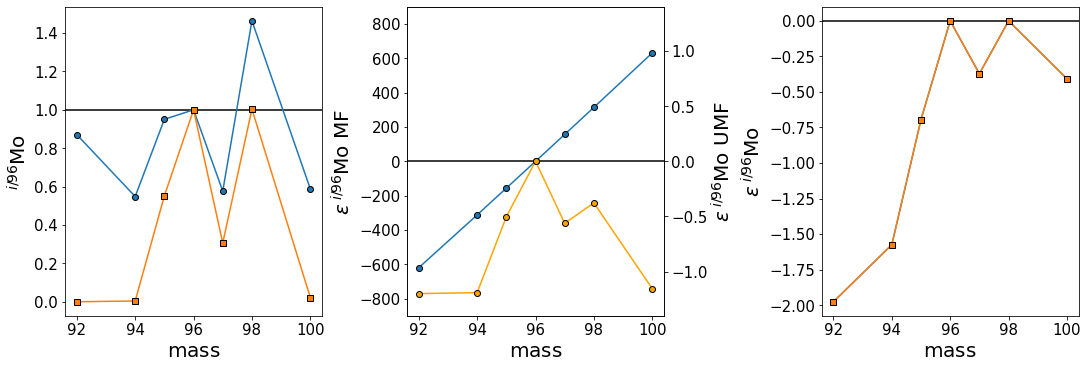

In [5]:
normrat = isopy.keystring('98mo/96mo')
solar_mo = solar_L09.to_array(element_symbol='mo')
model_mo = solar_mo * isopy.refval.isotope.sprocess_fraction_B11
mass_mo = mass.to_array(solar_mo.keys).ratio('96mo')

# Create the subplots for our final figure
axes = isopy.tb.create_subplots(plt, [['one', ('twol', 'twor'), 'three']], figure_width=15, figure_height=5)

isopy.tb.update_axes(axes.one, xlabel=r'$\rm{mass}$', ylabel=r'$^{i/96}\rm{Mo}$')
isopy.tb.update_axes(axes.twol, ylim=(-900, 900), ylabel=r'$\epsilon\:^{i/96} \rm{Mo}$ MF', xlabel=r'$\rm{mass}$')
isopy.tb.update_axes(axes.twor, ylim=(-1.4, 1.4), ylabel=r'$\epsilon\: ^{i/96} \rm{Mo}$ UMF')
isopy.tb.update_axes(axes.three, xlabel=r'$\rm{mass}$', ylabel=r'$\epsilon\:^{i/96} \rm{Mo}$')

axes.one.axhline(1, color='black')
axes.twol.axhline(0, color='black')
axes.three.axhline(0, color='black')

# Plot the solar and s-process abundance relative to 96Mo
isopy.tb.plot_spider(axes.one, solar_mo.ratio('96mo'), constants={96:1})
isopy.tb.plot_spider(axes.one, model_mo.ratio('96mo'), constants={96:1})

# Create the synthetic samples
sample_UMF = (solar_mo + model_mo * 1E-4).ratio('96mo') # Add small amount of s-process material
sample_MF = sample_UMF / np.power(mass_mo, -1.5) # Add mass fractionation

# The beta value calculated from the samples
beta_UMF = np.log(solar_L09.get(normrat)/sample_UMF[normrat]) / np.log(mass.get(normrat))
beta_MF = np.log(solar_L09.get(normrat)/sample_MF[normrat]) / np.log(mass.get(normrat))

# Plot the samples on seperate y-axes
isopy.tb.plot_spider(axes.twol, ((sample_MF/solar_L09)-1)*10000, constants={96:0})
isopy.tb.plot_spider(axes.twor, ((sample_UMF/solar_L09)-1)*10000, constants={96:0}, color='orange')

# Correct for mass fractionationd
Q = np.log(mass_mo)/ np.log(mass_mo.get(normrat))

corrected_UMF = (sample_UMF/solar_L09)
corrected_UMF = (corrected_UMF * np.power(corrected_UMF.get(normrat), -Q) -1) * 1E4

corrected_MF = (sample_MF/solar_L09)
corrected_MF = (corrected_MF * np.power(corrected_MF.get(normrat), -Q) -1) * 1E4
    
# Plot the corrected values
isopy.tb.plot_spider(axes.three, corrected_UMF, constants={96:0})
isopy.tb.plot_spider(axes.three, corrected_MF, constants={96:0})
                
# Save the figure
#plt.savefig('Figure2-NormExample.png')

In [6]:
# The mass fractionation fractors for the samples
beta_UMF, beta_MF, (-1.5 + beta_UMF)

(0.001825745202876196, -1.498174254797119, -1.4981742547971237)

---
## Figure 3

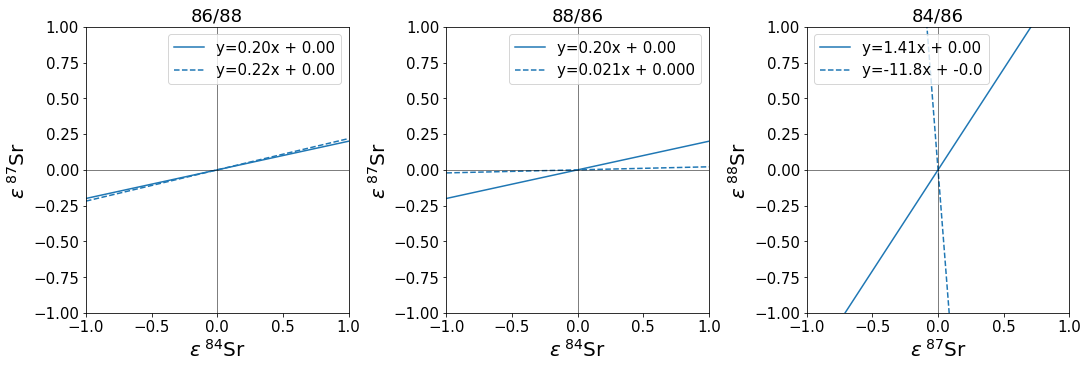

In [7]:
fig3_models = select_models(monash_models, name_eq = 'm3z014')

sr68_in = internal_normalisation(fig3_models, '86sr/88sr', solar_L09)
sr86_in = internal_normalisation(fig3_models, '88sr/86sr', solar_L09)
sr46_in = internal_normalisation(fig3_models, '84sr/86sr', solar_L09)

sr68_n = simple_normalisation(fig3_models, '88sr', solar_L09)
sr86_n = simple_normalisation(fig3_models, '86sr', solar_L09)
sr46_n = simple_normalisation(fig3_models, '86sr', solar_L09)

axes = create_subplots(3, (1,3))

plot_regression(axes.ax0, '84sr', '87sr', sr68_in, sr68_n, title='86/88')
plot_regression(axes.ax1, '84sr', '87sr', sr86_in, sr86_n, title='88/86')
plot_regression(axes.ax2, '87sr', '88sr', sr46_in, sr46_n, title='84/86')

axes.ax0.legend()
axes.ax1.legend()
axes.ax2.legend()

#plt.savefig('Figure3-Sr.png')

---
## Figure 4

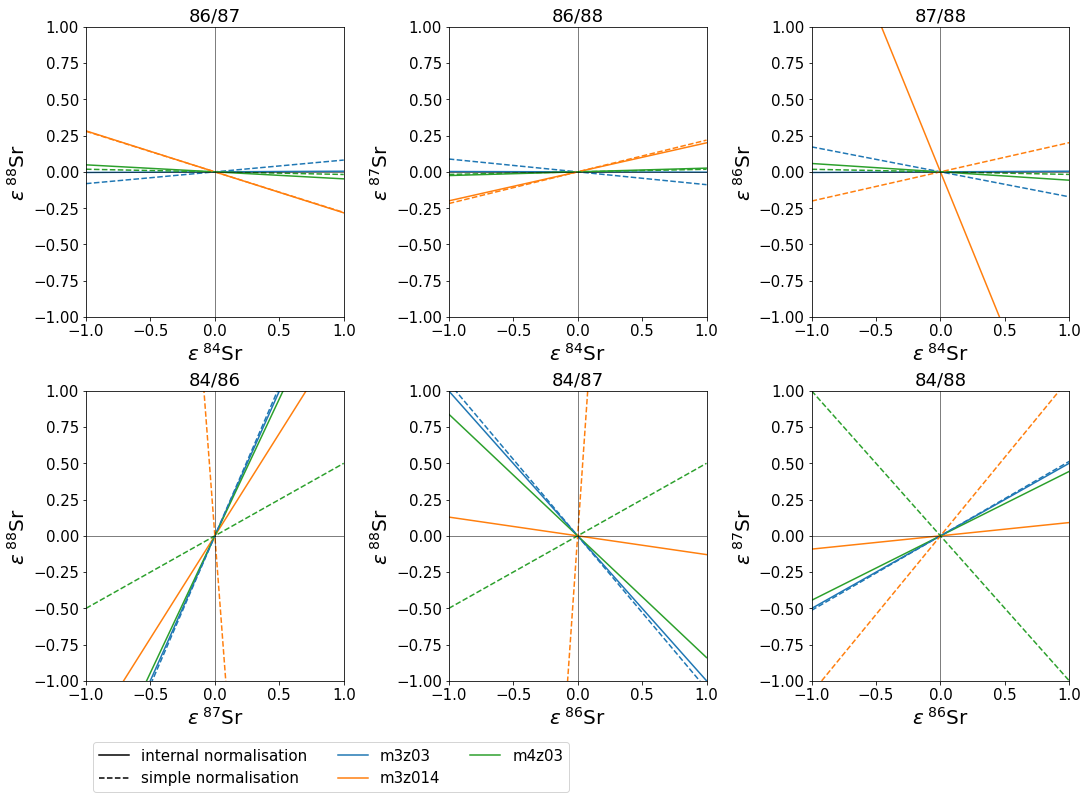

In [8]:
fig4_models = select_models(monash_models)

sr67_in = internal_normalisation(fig4_models, '86sr/87sr', solar_L09)
sr68_in = internal_normalisation(fig4_models, '86sr/88sr', solar_L09)
sr78_in = internal_normalisation(fig4_models, '87sr/88sr', solar_L09)
sr46_in = internal_normalisation(fig4_models, '84sr/86sr', solar_L09)
sr47_in = internal_normalisation(fig4_models, '84sr/87sr', solar_L09)
sr48_in = internal_normalisation(fig4_models, '84sr/88sr', solar_L09)

sr67_n = simple_normalisation(fig4_models, '87sr', solar_L09)
sr68_n = simple_normalisation(fig4_models, '88sr', solar_L09)
sr78_n = simple_normalisation(fig4_models, '88sr', solar_L09)
sr46_n = simple_normalisation(fig4_models, '86sr', solar_L09)
sr47_n = simple_normalisation(fig4_models, '87sr', solar_L09)
sr48_n = simple_normalisation(fig4_models, '88sr', solar_L09)

axes = create_subplots(6, (-1,3), legend=True, legend_ratio = 0.2)

plot_regression(axes.ax0, '84sr', '88sr', sr67_in, sr67_n, title='86/87')
plot_regression(axes.ax1, '84sr', '87sr', sr68_in, sr68_n, title='86/88')
plot_regression(axes.ax2, '84sr', '86sr', sr78_in, sr78_n, title='87/88')

plot_regression(axes.ax3, '87sr', '88sr', sr46_in, sr46_n, title='84/86')
plot_regression(axes.ax4, '86sr', '88sr', sr47_in, sr47_n, title='84/87')
plot_regression(axes.ax5, '86sr', '87sr', sr48_in, sr48_n, title='84/88')

create_legend(axes.legend, fig4_models['name'], 'internal normalisation', 'simple normalisation')

#plt.savefig('Figure4-Sr.png')

---
## Figure 5

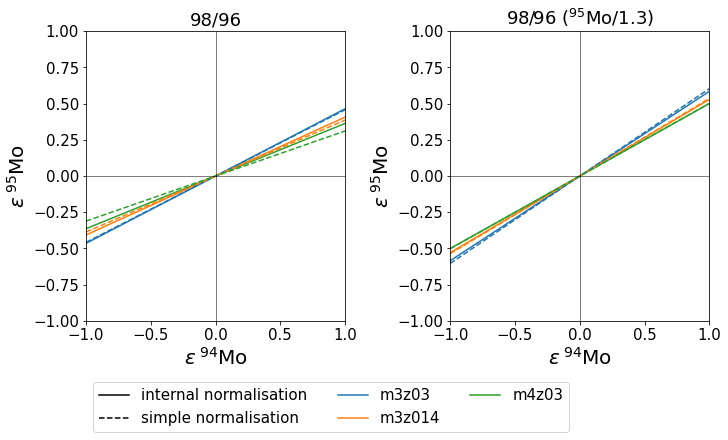

In [11]:
fig5_models1 = select_models(monash_models)

fig5_models2 = select_models(monash_models)
fig5_models2['abundance']['95mo'] = fig5_models2['abundance']['95mo'] / 1.3

mo86_in = internal_normalisation(fig5_models1, '98mo/96mo', solar_L09)
mo86_in2 = internal_normalisation(fig5_models2, '98mo/96mo', solar_L09)

mo86_n = simple_normalisation(fig5_models1, '96mo', solar_L09)
mo86_n2 = simple_normalisation(fig5_models2, '96mo', solar_L09)

axes = create_subplots(2, (1,2), legend=True, legend_ratio = 0.2)

plot_regression(axes.ax0, '94mo', '95mo', mo86_in, mo86_n, title='98/96')
plot_regression(axes.ax1, '94mo', '95mo', mo86_in2, mo86_n2, title=r'98/96 ($^{95}\rm{Mo}/1.3$)')

create_legend(axes.legend, fig5_models1['name'], 'internal normalisation', 'simple normalisation')

#plt.savefig('Figure5-Mo.png')

# Normalisation Comparison
---

The following creates a excel file comparing the different internal normalisation methods and solar values for each normalisation ratio listed in Table 1.

Each sheet contains the values from the exponential, linear and dauphas internal normalisations for Lodders et al 2009 and Anders & Grevesse 1989 solar values, as is and renormalised to the values listed in Table 1. Also included is each set of values divided by the Lodders 2009 exponential values and a figure of the different regressions for each solar value.

**Note creating the figures is time consuming and is disabled by default!**

In [10]:
def create_summary(filename, models, normalisation_ratios, include_figures = True):
    # Creates a progress bar so we can see the progress
    normalisation_ratios = np.asarray(normalisation_ratios)
    progress = ipywidgets.IntProgress(min = 0, max = normalisation_ratios.ncols, step=1)
    display(progress)

    # Create a in-memory file
    file = openpyxl.Workbook()
    xlsx_kwargs = dict(append=True, clear=False)

    # Use all the models
    model_names = isopy.array(name = models['name'])

    row1 = 1
    row2 = row1 + model_names.nrows + 3 + 1
    row3 = row2 + model_names.nrows + 3 + 1

    # Loop through all the internal normalisations given in Table 1
    for norm_ratio, norm_value in normalisation_ratios.items():
        norm_ratio = isopy.askeystring(norm_ratio, flavour='ratio[isotope, isotope]')
        norm_value = np.float64(norm_value)
        
        solar_L09_renorm = recalculate_solar(solar_L09, norm_ratio,  norm_value)
        solar_AG89_renorm = recalculate_solar(solar_AG89, norm_ratio,  norm_value)

        exponential_L09 = internal_normalisation(models, norm_ratio, solar_L09, linear=False)
        linear_L09 = internal_normalisation(models, norm_ratio, solar_L09, linear=True)
        linear_L09r = internal_normalisation(models, norm_ratio, solar_L09_renorm, linear=True)
        dauphas_L09 = dauphas_normalisation(models, norm_ratio, solar_L09)

        exponential_AG89 = internal_normalisation(models, norm_ratio, solar_AG89, linear=False)
        linear_AG89 = internal_normalisation(models, norm_ratio, solar_AG89, linear=True)
        linear_AG89r = internal_normalisation(models, norm_ratio, solar_AG89_renorm, linear=True)
        dauphas_AG89 = dauphas_normalisation(models, norm_ratio, solar_AG89)

        sheetname = norm_ratio.replace('/', '_')

        col = 1

        # model names
        model_names.to_xlsx(file, sheetname = sheetname, start_at=(row1, col),
                            comments = 'Model name', **xlsx_kwargs)

        model_names.to_xlsx(file, sheetname = sheetname, start_at=(row2, col),
                            comments = 'Model name', **xlsx_kwargs)

        col += model_names.ncols + 1

        ##########################
        ### Lodders et al 2009 ###
        ##########################

        # exponential equation
        data = exponential_L09
        comment = [' Exponential L09', f' {norm_ratio} = {solar_L09.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        # linear equation
        data = linear_L09
        comment = [' Linear L09', f' {norm_ratio} = {solar_L09.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs)

        data = linear_L09 / exponential_L09
        comment = ' Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        # Linear renormalised solar
        data = linear_L09r
        comment = [' Linear L09 renormalised', f' {norm_ratio} = {solar_L09_renorm.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs)

        data = linear_L09r / exponential_L09
        comment = ' Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        # Dauphas
        data = dauphas_L09
        comment = [' Dauphas L09', f' {norm_ratio} = {solar_L09.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs)

        data = dauphas_L09 / exponential_L09
        comment = ' Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1
        
        if include_figures:
            plt.clf() # Clear current plot
            try:
                fig = plot_all(model_names['name'], 
                               exponential_L09=exponential_L09,
                               linear_L09=linear_L09,
                               linear_L09_renormalised = linear_L09r,
                               dauphas_L09 = dauphas_L09)
            except:
                print(f'Error creating figure for {norm_ratio} L09')
            else:
                image = io.BytesIO()
                plt.savefig(image, transparent=False, facecolor='white')

                img = openpyxl.drawing.image.Image(image)
                img.anchor = f'A{row3}'
                file[sheetname].add_image(img)

        ##############################
        ### Anders & Grevasse 1989 ###
        ##############################

        # exponential equation
        data = exponential_AG89
        comment = [' Exponential AG89', f' {norm_ratio} = {solar_AG89.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs)

        data = exponential_AG89 / exponential_L09
        comment = ' Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        # linear equation
        data = linear_AG89
        comment = [' Linear AG89', f' {norm_ratio} = {solar_AG89.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs)

        data = linear_AG89 / exponential_L09
        comment = ' Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        # Linear renormalised solar
        data = linear_AG89r
        comment = [' Linear AG89 renormalised', f' {norm_ratio} = {solar_AG89_renorm.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs)

        data = linear_AG89r / exponential_L09
        comment = ' Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        # Dauphas
        data = dauphas_AG89
        comment = [' Dauphas AG89', f' {norm_ratio} = {solar_AG89.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs)

        data = dauphas_AG89 / exponential_L09
        comment = ' Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        progress.value += 1
        
        if include_figures:
            plt.clf() # Clear current plot
            try:
                fig = plot_all(model_names['name'], 
                               exponential_AG89=exponential_AG89,
                               linear_AG89=linear_AG89,
                               linear_AG89_renormalised = linear_AG89r,
                               dauphas_AG89 = dauphas_AG89)
            except:
                print(f'Error creating figure for {norm_ratio} AG89')
            else:
                image = io.BytesIO()
                plt.savefig(image, transparent=False, facecolor='white')

                img = openpyxl.drawing.image.Image(image)
                img.anchor = f'Q{row3}'
                file[sheetname].add_image(img)

    file.save(filename)

summary_models = select_models(fruity_models, m_in=[3, 4])
#create_summary('NormalisationComparison.xlsx', summary_models, normrat_values, include_figures=False)